In [19]:
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader
from tqdm import tqdm  # For nice progress bar!
import matplotlib.pyplot as plt

Load the Data

In [20]:
train_dataset = datasets.CIFAR10(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.CIFAR10(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)

In [21]:
type(train_dataset)

torchvision.datasets.cifar.CIFAR10

Randomly Printing some images

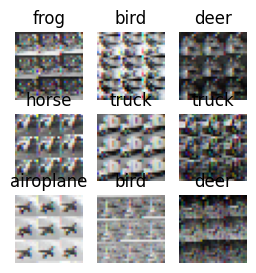

In [22]:
labels_map = {
    0: "airoplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(3, 3))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.reshape(32, 32, 3))
plt.show()

Just one batch process

In [23]:
batch_size = 1
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
torch.manual_seed(24)
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8, # No. of filters
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16, # No. of filters
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.fc1 = nn.Linear(16*8*8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        print("Input:",x.shape)
        x = F.relu(self.conv1(x))
        print("After 1st Conv:",x.shape)
        x = self.pool(x)
        print("After Pooling:",x.shape)
        x = F.relu(self.conv2(x))
        print("After 2nd Conv:",x.shape)
        x = self.pool(x)
        print("After Pooling:",x.shape)
        x = x.reshape(x.shape[0], -1)
        print("After Flattening:",x.shape)
        x = self.fc1(x)
        print("After FC1:",x.shape)
        x = self.fc2(x)
        print("Output:",x.shape)
        return x

Setting the device

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
device

device(type='cpu')

Hyper-Parameters

In [27]:
in_channels = 3
num_classes = 10
learning_rate = 0.01
num_epochs = 3

Processing of a single batch

In [28]:
model = CNN(in_channels=in_channels, num_classes=num_classes)
train_features, train_labels = next(iter(train_loader))
model(train_features)

Input: torch.Size([1, 3, 32, 32])
After 1st Conv: torch.Size([1, 8, 32, 32])
After Pooling: torch.Size([1, 8, 16, 16])
After 2nd Conv: torch.Size([1, 16, 16, 16])
After Pooling: torch.Size([1, 16, 8, 8])
After Flattening: torch.Size([1, 1024])
After FC1: torch.Size([1, 512])
Output: torch.Size([1, 10])


tensor([[-0.0515,  0.0320, -0.0897, -0.0237,  0.0132,  0.1425, -0.0383, -0.1345,
         -0.0273, -0.0753]], grad_fn=<AddmmBackward0>)

All the batches

In [29]:
batch_size = 32
torch.manual_seed(24)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
torch.manual_seed(24)
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8, # No. of filters
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16, # No. of filters
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.fc1 = nn.Linear(16*8*8, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        #print("Input:",x.shape)
        x = F.relu(self.conv1(x))
        #print("After 1st Conv:",x.shape)
        x = self.pool(x)
        #print("After Pooling:",x.shape)
        x = F.relu(self.conv2(x))
        #print("After 2nd Conv:",x.shape)
        x = self.pool(x)
        #print("After Pooling:",x.shape)
        x = self.dropout1(x)
        x = x.reshape(x.shape[0], -1)
        #print("After Flattening:",x.shape)
        x = self.fc1(x)
        #print("After FC1:",x.shape)
        x = self.dropout2(x)
        x = self.fc2(x)
        #print("Output:",x.shape)
        return x

Initialize the network

In [31]:
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

Loss and optimizer

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Train Network

In [33]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()





100%|██████████| 1563/1563 [00:24<00:00, 62.55it/s]


##### Check accuracy on training & test to see how good our model

In [34]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


In [35]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 25.75
Accuracy on test set: 25.74
